## Gaussian Mixture Model (Fall 2022)

## Set up
The below cell imports the required libraries for this project. This notebook is tested under [python 3.\**.\**](https://www.python.org/downloads/release/python-368/), and the corresponding packages can be downloaded from [miniconda](https://docs.conda.io/en/latest/miniconda.html). 

In [3]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

%matplotlib inline  

import sys
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from tqdm import tqdm

print('Version information')

print('python: {}'.format(sys.version))
print('matplotlib: {}'.format(matplotlib.__version__))
print('numpy: {}'.format(np.__version__))

# Load image
import imageio

%load_ext autoreload
%autoreload 2

Version information
python: 3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]
matplotlib: 3.5.2
numpy: 1.23.1


## GMM Math

A Gaussian Mixture Model(GMM) is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian Distribution. In a nutshell, GMM is a soft clustering algorithm in a sense that each data point is assigned to a cluster with a probability. In order to do that, we need to convert our clustering problem into an inference problem.

Given $N$ samples $X = [x_1, x_2, \ldots, x_N]^T$, where $x_i \in \mathbb{R}^D$. Let $\pi$ be a K-dimensional probability density function and $(\mu_k; \Sigma_k)$ be the mean and covariance matrix of the $k^{th}$ Gaussian distribution in $\mathbb{R}^d$. 

The GMM object implements EM algorithms for fitting the model and MLE for optimizing its parameters. It also has some particular hypothesis on how the data was generated:

- Each data point $x_i$ is assigned to a cluster $k$ with probability of $\pi_k$ where $\sum_{k=1}^K \pi_k = 1$
- Each data point $x_i$ is generated from Multivariate Normal Distribution $\cal{N}(\mu_k, \Sigma_k)$ where $\mu_k \in \mathbb{R}^D$ and $\Sigma_k \in \mathbb{R}^{D\times D}$

Our goal is to find a $K$-dimension Gaussian distributions to model our data $X$. This can be done by learning the parameters $\pi, \mu$ and $\Sigma$ through likelihood function. The log-likelihood function now becomes:

\begin{align}
    \text{ln } p(x_1, \dots, x_N | \pi, \mu, \Sigma) = \sum_{i=1}^N \text{ln } \big( \sum_{k=1}^{K} \pi(k) \mathcal{N}(x_i | \mu_k, \Sigma_k)\big)
\end{align}

We know that MLEs for GMM all depend on each other and the responsibility $\tau$. Thus, we need to use an iterative algorithm (the EM algorithm) to find the estimate of parameters that maximize our likelihood function.

- **E-step:** Evaluate the responsibilities

In this step, we need to calculate the responsibility $\tau$, which is the conditional probability that a data point belongs to a specific cluster $k$ if we are given the datapoint, i.e. $P(z_k|x)$. The formula for $\tau$ is given below:

$$
\tau\left(z_k\right)=\frac{\pi_{k} \cal{N}\left(x | \mu_{k}, \Sigma_{k}\right)}{\sum_{j=1}^{K} \pi_{j} \cal{N}\left(x | \mu_{j}, \Sigma_{j}\right)}, \quad \text{for } k = 1, \dots, K
$$
Note that each data point should have one probability for each component/cluster. For this project, we will work with $\tau\left(z_k\right)$ which has a size of $N\times K$ and all the responsibility values are in one matrix. **We use gamma as $\tau$ in this project**.

- **M-step:** Re-estimate Paramaters

After we obtained the responsibility, we can find the update of parameters, which are given below:

\begin{align}
\mu_k^{new} &= \dfrac{\sum_{n=1}^N \tau(z_k)x_n}{N_k} \\
\Sigma_k^{new} &= \dfrac{1}{N_k}\sum_{n=1}^N \tau (z_k)^T(x_n - \mu_k^{new})^T(x_n-\mu_k^{new}) \\
\pi_k^{new} &= \dfrac{N_k}{N}
\end{align}
where $N_k = \sum_{n=1}^N \tau(z_k)$. Note that the updated value for $\mu_k$ is used when updating $\Sigma_k$. The multiplication of $\tau (z_k)^T(x_n - \mu_k^{new})^T$ is element-wise so it will preserve the dimensions of $(x_n - \mu_k^{new})^T$.

- We repeat E and M steps until the incremental improvement to the likelihood function is small.


**Special Notes**
- For this project, we will assume that the covariance matrix $\Sigma$ is diagonal matrix, which means the features are independent. (i.e. the red intensity of a pixel is independent from its blue intensity, etc).


### Multivariate Gaussian PDF

Using the covariance matrix as a diagonal matrix with variances of the individual variables appearing on the main diagonal of the matrix and zeros everywhere else means that we assume the features are independent. In this case, the multivariate normal density function simplifies to the expression below:
$$\mathcal{N}(x: \mu, \Sigma) = \prod_{i=1}^D \frac{1}{\sqrt{2\pi\sigma_i^2}}\exp{\left( -\frac{1}{2\sigma_i^2} (x_i-\mu_i)^2\right)}$$
where $\sigma^2_i$ is the variance for the $i^{th}$ feature, which is the diagonal element of the covariance matrix.

### Notes on some of the Helper functions

- In these helper functions, "logit" refers to an input array of size $(N, D)$ that reperesents the unnormalized scores, that are passed to the softmax( ) or logsumexp( ) function.
- It is possible that $logit_{i, j}$ is very large, making $\exp(\cdot)$ of it to explode. To make sure it is numerically stable, we need to subtract the maximum for each row of $logits$.

### GMM Implementation


### Initialize parameters in \_init_components()

How we will initialize the parameters. 
  1. Set the prior probability $\pi$ the same for each class.
  2. Initialize $\mu$ by randomly selecting K numbers of observations as the initial mean vectors. 
  3. Initialize the covariance matrix with for each k.

### Formulate the log-likelihood function \_ll_joint()

The log-likelihood function is given by:
$$
\begin{align}
    \ell(\theta) = \sum_{i=1}^N \text{ln } \big( \sum_{k=1}^{K} \pi(k) \mathcal{N}(x_i | \mu_k, \Sigma_k)\big)
\end{align}
$$
In this part, we will generate a $(N,K)$ matrix where each datapoint $x_i, \forall i = 1, \dots, N$ has $K$ log-likelihood numbers. Thus, for each $i = 1, \dots, N$ and $k = 1, \dots, K$, 
$$
\text{log-likelihood}[i,k] = \log{\pi_k}+\log{\cal{N}(x_i|\mu_k, \Sigma_k)}
$$


### Function Tests ###

Use these to test if your implementation of functions in GMM work as expected. See [Using the Local Tests](#using_local_tests) for more details. 

## Using GMM for Image Compression and pixel clustering

Images typically need a lot of bandwidth to be transmitted over the network. In order to optimize this process, most image processors perform lossy compression of images (lossy implies some information is lost in the process of compression).

We will use our GMM algorithm implementation to do pixel clustering and compress the images. That is to say, you would develop a lossy image compression algorithm.


In [6]:
from gmm import GMM

# helper function for performing pixel clustering. 
def cluster_pixels_gmm(image, K, full_matrix = True):
    """Clusters pixels in the input image
    
    Args:
        image: input image of shape(H, W, 3)
        K: number of components
    Return:
        clustered_img: image of shape(H, W, 3) after pixel clustering
    """
    im_height, im_width, im_channel = image.shape
    flat_img = np.reshape(image, [-1, im_channel]).astype(np.float32)
    gamma, (pi, mu, sigma) = GMM(flat_img, K = K, max_iters = 10)(full_matrix)
    cluster_ids = np.argmax(gamma, axis=1)
    centers = mu

    gmm_img = np.reshape(centers[cluster_ids], (im_height, im_width, im_channel))
    return gmm_img

# helper function for plotting images.
def plot_images(img_list, title_list, figsize=(20, 10)):
    assert len(img_list) == len(title_list)
    fig, axes = plt.subplots(1, len(title_list), figsize=figsize)
    for i, ax in enumerate(axes):
        ax.imshow(img_list[i] / 255.0)
        ax.set_title(title_list[i])
        ax.axis('off')

iter 9, loss: 3223607.9833: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


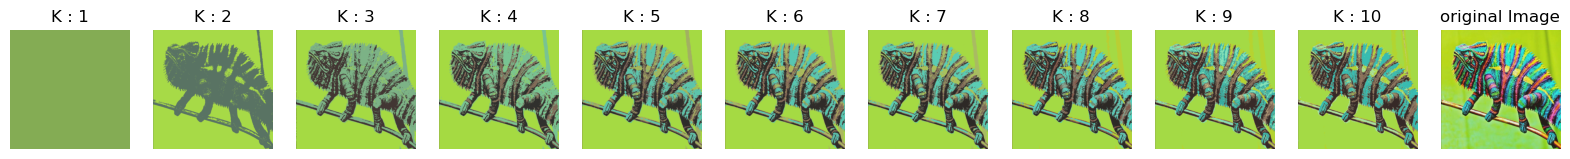

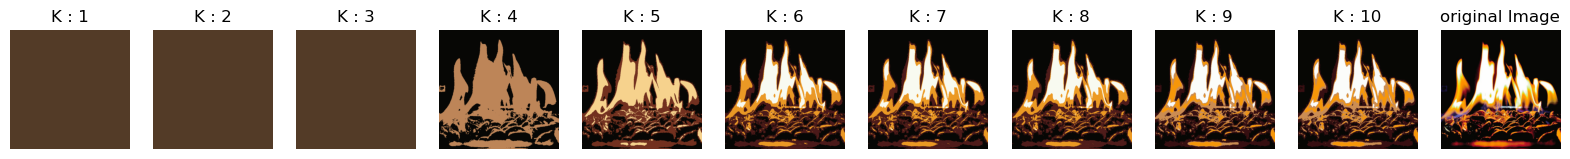

In [7]:
# the direction of two images. Both of them are from ImageNet

img1_dir ='./data/images/gmm-example1.png'
img2_dir ='./data/images/gmm-example2.png'

# loading image 
image1 = imageio.v2.imread('./data/images/gmm-example1.png')
image2 = imageio.v2.imread('./data/images/gmm-example2.png')


def perform_compression(image, min_clusters=5, max_clusters=15):
    """
    Using the helper function above to find the optimal number of clusters that can appropriately produce a single image.
    
    Args:
        image: input image of shape(H, W, 3)
        min_clusters, max_clusters: the minimum and maximum number of clusters. Default are 5 and 15.
        (Usually the maximum number of clusters would not exeed 15)
        
    Return:
        plot: comparison between original image and image pixel clustering.
        optional: any other information/metric/plots necessary.
    """
    
    img_list = [image] * (max_clusters - min_clusters + 1)
    title_list = []

    #We start from min # to max
    for i in range(min_clusters, max_clusters):
        new_image = cluster_pixels_gmm(image, i, full_matrix = False)
        img_list[i - min_clusters] = new_image
        title_list.append("K : " + str(i))
        #print(title_list[i])
    img_list[max_clusters - min_clusters] = image
    title_list.append("original Image")
    plot_images(img_list, title_list)


perform_compression(image1, 1, 11)
perform_compression(image2, 1, 11)

## Generate samples from a Gaussian Mixture

In this part, we will be fitting our GMM implementation on a 2D Gaussian Mixture to estimate the parameters of the distributions that make up the mixture, and then using these estimated parameters to generate samples.


(1000, 2)


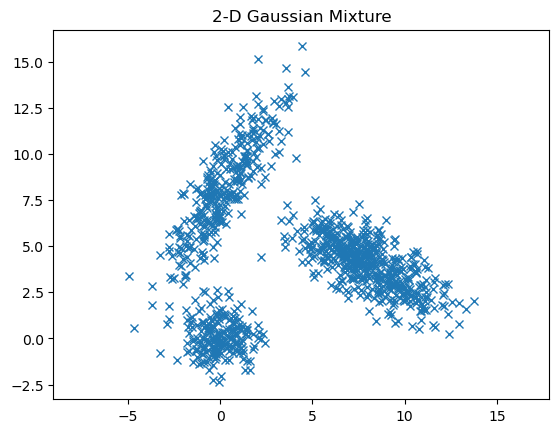

In [8]:
data = np.load('./data/mixture.npy')
print(data.shape)

plt.plot(data[:,0], data[:,1], 'x')
plt.axis('equal')
plt.title('2-D Gaussian Mixture')
plt.show()

Now, we need to estimate the parameters of the Gaussian Mixture, and then use these estimated parameters to generate 1000 samples from the Gaussian Mixture.

**Steps**
- To estimate the parameters of the Gaussian Mixture, we need to fit our GMM implementation to the dataset. We will specify that K = 3, and run the EM algorithm.
- Once we obtain the estimated parameters, we'll need to sample 1000 datapoints from the Gaussian Mixture. We will be using a technique known as Rejection Sampling. Links to understand how Rejection Sampling works: 

- https://cosmiccoding.com.au/tutorials/rejection_sampling
- https://towardsdatascience.com/rejection-sampling-with-python-d7a30cfc327b

- The formula for the density function is: $f(x_i) = \sum_{k=1}^{K} \pi(k) \mathcal{N}(x_i | \mu_k, \Sigma_k)$

In [9]:

gamma, (pi, mu, sigma) = GMM(data, K = 3, max_iters = 4)(full_matrix=False)


# print the estimated parameters
print(pi, '\n')
print(mu, '\n')
print(sigma)

iter 3, loss: 4773.6070: 100%|██████████| 4/4 [00:00<00:00, 36.93it/s]

[0.49829625 0.17911993 0.32258382] 

[[ 7.91988235  4.08318395]
 [-0.01117926 -0.01843011]
 [ 0.13050896  7.69718855]] 

[[[ 3.93611423 -0.        ]
  [-0.          1.99750624]]

 [[ 1.01172459  0.        ]
  [ 0.          0.68104675]]

 [[ 2.66518326  0.        ]
  [ 0.          9.19928273]]]


In [10]:
# Extract x and y
x = data[:, 0]
y = data[:, 1]

# Define the borders of the grid
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY


# Create meshgrid
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
# coordinates of the points that make the grid
positions = np.vstack([xx.ravel(), yy.ravel()]).T 

In [11]:
def density(points, pi, mu, sigma, gmm):
    """Evaluate the density at each point on the grid.
    Args:
        points: (N, 2) numpy array containing the coordinates of the points that make up the grid. 
        pi: (K,) numpy array containing the mixture coefficients for each class
        mu: (K, D) numpy array containing the means of each cluster
        sigma: (K, D, D) numpy array containing the covariance matrixes of each cluster
        gmm: an instance of the GMM model
        
    Return:
        densities: (N, ) numpy array containing densities at each point on the grid
    """
 
    densities = np.zeros(points.shape[0])
    #print(densities)
    for i in range(pi.shape[0]):
        densities = densities + (pi[i] * gmm.normalPDF(gmm, points, mu[i], sigma[i]))
        #print(densities)

    return densities

# get the density at each coordinate on the grid
densities = np.reshape(density(positions, pi, mu, sigma, GMM), xx.shape)

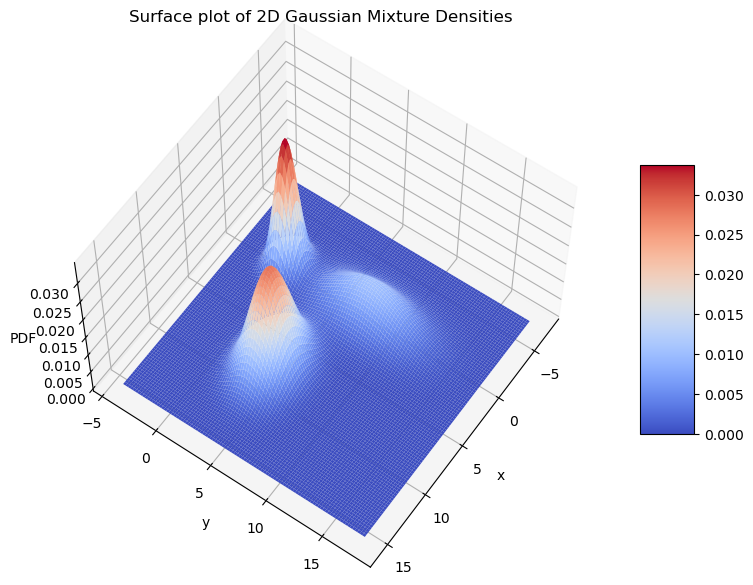

In [12]:
fig = plt.figure(figsize=(13, 7))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(xx, yy, densities, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('PDF')
ax.set_title('Surface plot of 2D Gaussian Mixture Densities')
fig.colorbar(surf, shrink=0.5, aspect=5) # add color bar indicating the PDF
ax.view_init(60, 35)

Text(0.5, 0.92, 'Wireframe plot of 2D Gaussian Mixture')

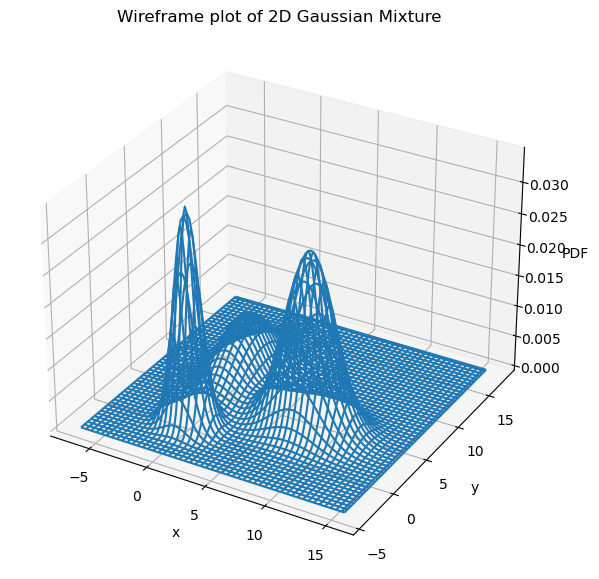

In [13]:
fig = plt.figure(figsize=(13, 7))
ax = plt.axes(projection='3d')
w = ax.plot_wireframe(xx, yy, densities)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('PDF')
ax.set_title('Wireframe plot of 2D Gaussian Mixture')

In [14]:
def sample(xmin, xmax, ymin, ymax, gmm, dmax=1, M=0.1):
    """Performs rejection sampling. Keep sampling datapoints until d <= f(x, y) / M
    Args:
        xmin: lower bound on x values
        xmax: upper bound on x values 
        ymin: lower bound on y values
        ymax: upper bound on y values
        gmm: an instance of the GMM model
        dmax: the upper bound on d
        M: scale_factor. can be used to control the fraction of samples that are rejected
        
    Return:
        x, y: the coordinates of the sampled datapoint
    """
    while True:
        x = np.random.uniform(low=xmin, high=xmax)
        y = np.random.uniform(low=ymin, high=ymax)
        d = np.random.uniform(low=0, high=dmax)
        if d < density(np.array([x,y]).reshape(1,2), pi, mu, sigma, gmm) / M:
            return x, y

In [15]:
# Sample datapoints using Rejection Sampling
generated_datapoints = np.zeros((1000, 2))
i = 0
while i < 1000:
    generated_datapoints[i,0], generated_datapoints[i,1] = sample(xmin, xmax, ymin, ymax, GMM, dmax=1)
    if i % 100 == 0:
        print(i)
    i += 1 

0
100
200
300
400
500
600
700
800
900


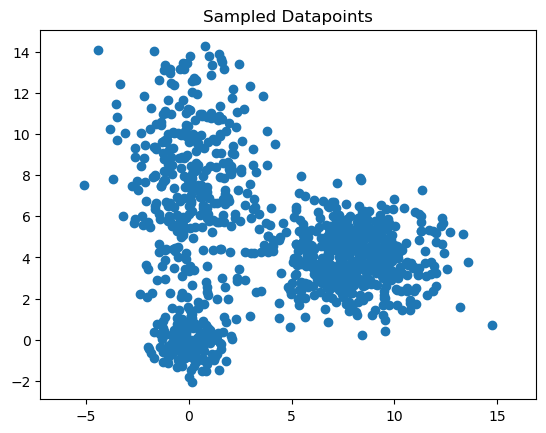

In [16]:
plt.scatter(generated_datapoints[:,0], generated_datapoints[:,1])
plt.axis('equal')
plt.title('Sampled Datapoints')
plt.show()